# GenAI Multi Agent Demo with LangGraph & LangChain OpenAI

## Building simple Multi Agent 

In [ ]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchResults
from typing import Literal, Annotated
from typing_extensions import TypedDict

from pprint import pprint
from rich import print as rprint
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

# from semantic_router.utils.function_call import FunctionSchema
from langchain_experimental.utilities import PythonREPL
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = 'key'


### Invoking LLM

In [ ]:
# llm = OpenAI(model="gpt-3.5-turbo", temperature=0.7)  # Replace with your model if needed
model = "gpt-3.5-turbo" #"gpt-3.5-turbo-0125"
llm = ChatOpenAI(model=model, max_tokens=4096, temperature=0.1)

llm.invoke('what is Milk?')

### Creating Tools and Mini Agents

In [21]:
repl = PythonREPL()
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_agent.invoke({'messages':'Create random number with random in python'})

{'messages': [HumanMessage(content='Create random number with random in python', additional_kwargs={}, response_metadata={}, id='a70bf51b-b86a-4e2f-b1ed-e0fe3b9a01cf'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uT5iy1Mac6WWYYoCBCu5tuI5', 'function': {'arguments': '{"code":"import random\\n\\n# Generate a random number between 1 and 100\\nrandom_number = random.randint(1, 100)\\nrandom_number"}', 'name': 'python_repl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 98, 'total_tokens': 144, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5b1fef4b-e632-4ce5-94ed-d392731b0d1e-0', tool_calls=[{'name': 'python_rep

In [5]:
# help(create_react_agent)

In [22]:
# @tool("tool_browser")
# def tool_browser(q: str) -> str:
#     """Search on DuckDuckGo browser by passing the input `q`"""
#     return DuckDuckGoSearchRun().run(q)

# # test
# print( tool_browser("What is milk?") )

search_tool = DuckDuckGoSearchResults()
research_agent = create_react_agent(
    llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math."
)


research_agent.invoke({'messages':'What is Milk?'})

{'messages': [HumanMessage(content='What is Milk?', additional_kwargs={}, response_metadata={}, id='d910a947-2056-44b9-b1ae-2d9166548f25'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CoK15wu7qqt0kvxSSCLA2lNG', 'function': {'arguments': '{"query":"Milk"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 91, 'total_tokens': 111, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fcfa3cfc-824b-4a46-8f68-5a8089507712-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'Milk'}, 'id': 'call_CoK15wu7qqt0kvxSSCLA2lNG', 'type': 'tool_call'}], usage_metadata={'input_tokens': 

### Initiating System Prompt and States

In [13]:
class State(MessagesState):
    next: str
    
    
members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]
pprint(system_prompt)

('You are a supervisor tasked with managing a conversation between the '
 "following workers: ['researcher', 'coder']. Given the following user "
 'request, respond with the worker to act next. Each worker will perform a '
 'task and respond with their results and status. When finished, respond with '
 'FINISH.')


### Creating nodes for the graph

In [23]:
## Suprevisor Node
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

## Researcher Node

def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

# REPL Node

def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

### Build the graph and vizulise

In [24]:
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

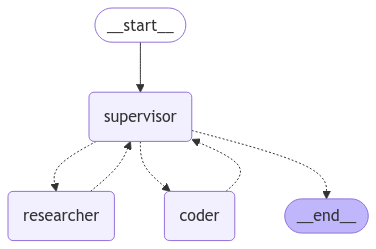

In [25]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### Time To test

In [ ]:
# import mdformat

for s in graph.stream({"messages": [("user", "Print Hello world in python")]}, subgraphs=True):
    print(s[0])
    # print(json.dumps(s[1]))
    rprint(s[1])
    rprint("----")

c:\Users\jitinkapila\micromamba\envs\genai\Lib\site-packages\langchain_openai\chat_models\base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


()


{'supervisor': {'next': 'coder'}}

----

('coder:40062254-e746-e6de-19f2-34abcd064932',)


{
    'agent': {
        'messages': [
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_ZGeCAwxDwYWcQUDCNlY6xIK1',
                            'function': {
                                'arguments': '{"code":"print(\'Hello world\')"}',
                                'name': 'python_repl_tool'
                            },
                            'type': 'function'
                        }
                    ],
                    'refusal': None
                },
                response_metadata={
                    'token_usage': {
                        'completion_tokens': 21,
                        'prompt_tokens': 96,
                        'total_tokens': 117,
                        'completion_tokens_details': {
                            'accepted_prediction_tokens': 0,
                            'audio_tokens': 0,
                            'reasoning_tokens': 0,
                            'rejected_prediction_tokens': 0
                        },
                        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                    },
                    'model_name': 'gpt-3.5-turbo-0125',
                    'system_fingerprint': None,
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                id='run-fa2be75a-a5e7-440a-805a-8746a3ab2068-0',
                tool_calls=[
                    {
                        'name': 'python_repl_tool',
                        'args': {'code': "print('Hello world')"},
                        'id': 'call_ZGeCAwxDwYWcQUDCNlY6xIK1',
                        'type': 'tool_call'
                    }
                ],
                usage_metadata={
                    'input_tokens': 96,
                    'output_tokens': 21,
                    'total_tokens': 117,
                    'input_token_details': {'audio': 0, 'cache_read': 0},
                    'output_token_details': {'audio': 0, 'reasoning': 0}
                }
            )
        ]
    }
}

----

('coder:40062254-e746-e6de-19f2-34abcd064932',)


{
    'tools': {
        'messages': [
            ToolMessage(
                content="Successfully executed:\n```python\nprint('Hello world')\n```\nStdout: Hello world\n",
                name='python_repl_tool',
                id='ad85543c-901c-4dca-aa4f-4439f5e0b83e',
                tool_call_id='call_ZGeCAwxDwYWcQUDCNlY6xIK1'
            )
        ]
    }
}

----

('coder:40062254-e746-e6de-19f2-34abcd064932',)


{
    'agent': {
        'messages': [
            AIMessage(
                content='Hello world has been printed in Python.',
                additional_kwargs={'refusal': None},
                response_metadata={
                    'token_usage': {
                        'completion_tokens': 10,
                        'prompt_tokens': 145,
                        'total_tokens': 155,
                        'completion_tokens_details': {
                            'accepted_prediction_tokens': 0,
                            'audio_tokens': 0,
                            'reasoning_tokens': 0,
                            'rejected_prediction_tokens': 0
                        },
                        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                    },
                    'model_name': 'gpt-3.5-turbo-0125',
                    'system_fingerprint': None,
                    'finish_reason': 'stop',
                    'logprobs': None
                },
                id='run-f4985568-c0d2-4629-b17d-fa5913f362b0-0',
                usage_metadata={
                    'input_tokens': 145,
                    'output_tokens': 10,
                    'total_tokens': 155,
                    'input_token_details': {'audio': 0, 'cache_read': 0},
                    'output_token_details': {'audio': 0, 'reasoning': 0}
                }
            )
        ]
    }
}

----

()


{
    'coder': {
        'messages': [
            HumanMessage(
                content='Hello world has been printed in Python.',
                additional_kwargs={},
                response_metadata={},
                name='coder'
            )
        ]
    }
}

----

c:\Users\jitinkapila\micromamba\envs\genai\Lib\site-packages\langchain_openai\chat_models\base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


()


{'supervisor': {'next': '__end__'}}

----

In [46]:
while True:
    query = input('Query (use /exit to quit)')
    if query == '/exit':
        break
    
    for s in graph.stream( {"messages": [("user", query)]}, subgraphs=True):
        rprint(s)
        rprint("----")
    rprint("->"*80)
    

c:\Users\jitinkapila\micromamba\envs\genai\Lib\site-packages\langchain_openai\chat_models\base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


((), {'supervisor': {'next': 'coder'}})

----

(
    ('coder:5bb85296-21a0-24aa-485c-b807e09c552a',),
    {
        'agent': {
            'messages': [
                AIMessage(
                    content='',
                    additional_kwargs={
                        'tool_calls': [
                            {
                                'id': 'call_wD8Y9opgyKFk4Ek648YP5fhJ',
                                'function': {
                                    'arguments': '{"code":"import numpy as np\\nimport pandas as pd\\nimport 
statsmodels.api as sm\\n\\n# Generate some random data\\nnp.random.seed(0)\\nx = np.random.rand(100)\\ny = 2*x + 
np.random.normal(0, 0.1, 100)\\n\\n# Create a DataFrame\\ndf = pd.DataFrame({\'x\': x, \'y\': y})\\n\\n# Fit a 
linear regression model\\nX = sm.add_constant(df[\'x\'])\\nmodel = sm.OLS(df[\'y\'], X).fit()\\n\\n# Print the 
model summary\\nprint(model.summary())"}',
                                    'name': 'python_repl_tool'
                                },
                                'type': 'function'
                            }
                        ],
                        'refusal': None
                    },
                    response_metadata={
                        'token_usage': {
                            'completion_tokens': 141,
                            'prompt_tokens': 109,
                            'total_tokens': 250,
                            'completion_tokens_details': {
                                'accepted_prediction_tokens': 0,
                                'audio_tokens': 0,
                                'reasoning_tokens': 0,
                                'rejected_prediction_tokens': 0
                            },
                            'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                        },
                        'model_name': 'gpt-3.5-turbo-0125',
                        'system_fingerprint': None,
                        'finish_reason': 'tool_calls',
                        'logprobs': None
                    },
                    id='run-559fd5fd-612d-48ac-9d6f-57004d2b9fba-0',
                    tool_calls=[
                        {
                            'name': 'python_repl_tool',
                            'args': {
                                'code': "import numpy as np\nimport pandas as pd\nimport statsmodels.api as sm\n\n#
Generate some random data\nnp.random.seed(0)\nx = np.random.rand(100)\ny = 2*x + np.random.normal(0, 0.1, 100)\n\n#
Create a DataFrame\ndf = pd.DataFrame({'x': x, 'y': y})\n\n# Fit a linear regression model\nX = 
sm.add_constant(df['x'])\nmodel = sm.OLS(df['y'], X).fit()\n\n# Print the model summary\nprint(model.summary())"
                            },
                            'id': 'call_wD8Y9opgyKFk4Ek648YP5fhJ',
                            'type': 'tool_call'
                        }
                    ],
                    usage_metadata={
                        'input_tokens': 109,
                        'output_tokens': 141,
                        'total_tokens': 250,
                        'input_token_details': {'audio': 0, 'cache_read': 0},
                        'output_token_details': {'audio': 0, 'reasoning': 0}
                    }
                )
            ]
        }
    }
)

----

(
    ('coder:5bb85296-21a0-24aa-485c-b807e09c552a',),
    {
        'tools': {
            'messages': [
                ToolMessage(
                    content="Successfully executed:\n```python\nimport numpy as np\nimport pandas as pd\nimport 
statsmodels.api as sm\n\n# Generate some random data\nnp.random.seed(0)\nx = np.random.rand(100)\ny = 2*x + 
np.random.normal(0, 0.1, 100)\n\n# Create a DataFrame\ndf = pd.DataFrame({'x': x, 'y': y})\n\n# Fit a linear 
regression model\nX = sm.add_constant(df['x'])\nmodel = sm.OLS(df['y'], X).fit()\n\n# Print the model 
summary\nprint(model.summary())\n```\nStdout:                             OLS Regression Results                   
\n==============================================================================\nDep. Variable:                   
y   R-squared:                       0.971\nModel:                            OLS   Adj. R-squared:                
0.971\nMethod:                 Least Squares   F-statistic:                     3262.\nDate:                Wed, 29
Jan 2025   Prob (F-statistic):           4.88e-77\nTime:                        18:42:08   Log-Likelihood:         
88.744\nNo. Observations:                 100   AIC:                            -173.5\nDf Residuals:              
98   BIC:                            -168.3\nDf Model:                           1                                 
\nCovariance Type:            nonrobust                                         
\n==============================================================================\n                 coef    std err 
t      P>|t|      [0.025      
0.975]\n------------------------------------------------------------------------------\nconst          0.0222      
0.019      1.149      0.253      -0.016       0.061\nx              1.9937      0.035     57.117      0.000       
1.924       2.063\n==============================================================================\nOmnibus:        
11.746   Durbin-Watson:                   2.083\nProb(Omnibus):                  0.003   Jarque-Bera (JB):         
4.097\nSkew:                           0.138   Prob(JB):                        0.129\nKurtosis:                   
2.047   Cond. No.                         
4.30\n==============================================================================\n\nNotes:\n[1] Standard Errors
assume that the covariance matrix of the errors is correctly specified.\n",
                    name='python_repl_tool',
                    id='33e013e8-5f75-4a8f-8061-bb0806c05a0b',
                    tool_call_id='call_wD8Y9opgyKFk4Ek648YP5fhJ'
                )
            ]
        }
    }
)

----

(
    ('coder:5bb85296-21a0-24aa-485c-b807e09c552a',),
    {
        'agent': {
            'messages': [
                AIMessage(
                    content="Here is a simple code for generating a linear regression model with statsmodels in 
Python:\n\n```python\nimport numpy as np\nimport pandas as pd\nimport statsmodels.api as sm\n\n# Generate some 
random data\nnp.random.seed(0)\nx = np.random.rand(100)\ny = 2*x + np.random.normal(0, 0.1, 100)\n\n# Create a 
DataFrame\ndf = pd.DataFrame({'x': x, 'y': y})\n\n# Fit a linear regression model\nX = 
sm.add_constant(df['x'])\nmodel = sm.OLS(df['y'], X).fit()\n\n# Print the model 
summary\nprint(model.summary())\n```\n\nThis code generates random data, fits a linear regression model, and prints
the model summary including coefficients, p-values, and other statistics.",
                    additional_kwargs={'refusal': None},
                    response_metadata={
                        'token_usage': {
                            'completion_tokens': 166,
                            'prompt_tokens': 752,
                            'total_tokens': 918,
                            'completion_tokens_details': {
                                'accepted_prediction_tokens': 0,
                                'audio_tokens': 0,
                                'reasoning_tokens': 0,
                                'rejected_prediction_tokens': 0
                            },
                            'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                        },
                        'model_name': 'gpt-3.5-turbo-0125',
                        'system_fingerprint': None,
                        'finish_reason': 'stop',
                        'logprobs': None
                    },
                    id='run-e0029e66-90f1-4ced-96ea-b96fe64b4bad-0',
                    usage_metadata={
                        'input_tokens': 752,
                        'output_tokens': 166,
                        'total_tokens': 918,
                        'input_token_details': {'audio': 0, 'cache_read': 0},
                        'output_token_details': {'audio': 0, 'reasoning': 0}
                    }
                )
            ]
        }
    }
)

----

(
    (),
    {
        'coder': {
            'messages': [
                HumanMessage(
                    content="Here is a simple code for generating a linear regression model with statsmodels in 
Python:\n\n```python\nimport numpy as np\nimport pandas as pd\nimport statsmodels.api as sm\n\n# Generate some 
random data\nnp.random.seed(0)\nx = np.random.rand(100)\ny = 2*x + np.random.normal(0, 0.1, 100)\n\n# Create a 
DataFrame\ndf = pd.DataFrame({'x': x, 'y': y})\n\n# Fit a linear regression model\nX = 
sm.add_constant(df['x'])\nmodel = sm.OLS(df['y'], X).fit()\n\n# Print the model 
summary\nprint(model.summary())\n```\n\nThis code generates random data, fits a linear regression model, and prints
the model summary including coefficients, p-values, and other statistics.",
                    additional_kwargs={},
                    response_metadata={},
                    name='coder'
                )
            ]
        }
    }
)

----

c:\Users\jitinkapila\micromamba\envs\genai\Lib\site-packages\langchain_openai\chat_models\base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


((), {'supervisor': {'next': '__end__'}})

----

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->-
>->->->->->->->->->->->->->->->->->->->->->->

## Building Multi agent with Human-in-loop

In [ ]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchResults
from typing import Literal, Annotated
from typing_extensions import TypedDict

from pprint import pprint
from rich import print as rprint
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

# from semantic_router.utils.function_call import FunctionSchema
from langchain_experimental.utilities import PythonREPL
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = 'key'


In [2]:
import pandas as pd
import numpy as np
import json
from car_models import model_data 
from car_model_color import model_color
# car_data = pd.DataFrame(models_data)
# car_color = pd.DataFrame(model_color)
# display(car_data.head())
# display(car_color.head())


In [3]:
#selecting data for all next steps
make = 'Mercedes-Benz'
brand = 'MBUSA'
model_data = [model for model in model_data if model['make']==make and model['brand'] == brand]
model_color = [model for model in model_color if model['make']==make and model['brand'] == brand]
print('Number of Models',len(model_data))
print('Number of Models Color',len(model_color))

Number of Models 6
Number of Models Color 30


In [4]:
all_colors = list(set([mod['color_text'] for mod in model_color]))
all_names = list(set([mod['name'] for mod in model_data]))
all_body = list(set([mod['body_type'] for mod in model_data]))
all_drive = list(set([mod['category'] for mod in model_data]))
all_power = list(set([mod['engine_power'] for mod in model_data]))
all_price = list(set([mod['price'] for mod in model_data]))
print('Names:',all_names)
print('Colors:',all_colors)
print('Body-type:',all_body)
print('Drive:',all_drive)
print('Engine_power:',all_power)
print('Price:',all_price)
# model_data[3]

car_info = []
for mod in model_data:
    mod_val = { k:v for k,v in mod.items() if k in ['id','name','body_type','category','engine_power','price']}
    colors = list(set([mod['color_text'] for mod in model_color if mod['model_id'] == mod_val['id']]))
    mod_val['colors'] = colors
    print(mod_val)
    car_info.append(mod_val)
rprint(car_info)

Names: ['GLC 350e 4MATIC SUV', 'AMG EQE 4MATIC+ Sedan', '2024 AMG GT 43 4-Door Coupe', '2024 S 500 4MATIC Sedan', 'GLE 450 4MATIC SUV', '2024 EQS 580 4MATIC SUV']
Colors: ['Polar white', 'Patagon red metallic', 'Selenite grey metallic', 'Twilight blue metallic', 'Patagonia red bright', 'Nautical blue metallic', 'Patagonia red metallic', 'Obsidian black metallic', 'Cirrus silver metallic', 'Starling blue metallic', 'Rubellite red metallic', 'Black', 'Moon light', 'Cardinala red metallic']
Body-type: ['SUV', 'Sedan']
Drive: ['Electric', 'ICE', 'Hybrid']
Engine_power: [617, 362, 375, 536, 313, 442]
Price: [98500, 106900, 117300, 71350, 127350, 59900]
{'id': 39, 'name': 'GLC 350e 4MATIC SUV', 'price': 59900, 'engine_power': 313, 'body_type': 'SUV', 'category': 'Hybrid', 'colors': ['Black', 'Patagonia red metallic', 'Twilight blue metallic', 'Polar white']}
{'id': 40, 'name': 'GLE 450 4MATIC SUV', 'price': 71350, 'engine_power': 375, 'body_type': 'SUV', 'category': 'ICE', 'colors': ['Twilig

[
    {
        'id': 39,
        'name': 'GLC 350e 4MATIC SUV',
        'price': 59900,
        'engine_power': 313,
        'body_type': 'SUV',
        'category': 'Hybrid',
        'colors': ['Black', 'Patagonia red metallic', 'Twilight blue metallic', 'Polar white']
    },
    {
        'id': 40,
        'name': 'GLE 450 4MATIC SUV',
        'price': 71350,
        'engine_power': 375,
        'body_type': 'SUV',
        'category': 'ICE',
        'colors': [
            'Twilight blue metallic',
            'Polar white',
            'Cirrus silver metallic',
            'Black',
            'Cardinala red metallic'
        ]
    },
    {
        'id': 41,
        'name': '2024 AMG GT 43 4-Door Coupe',
        'price': 98500,
        'engine_power': 362,
        'body_type': 'Sedan',
        'category': 'ICE',
        'colors': [
            'Polar white',
            'Patagon red metallic',
            'Obsidian black metallic',
            'Cirrus silver metallic',
            'Starling blue metallic'
        ]
    },
    {
        'id': 42,
        'name': 'AMG EQE 4MATIC+ Sedan',
        'price': 106900,
        'engine_power': 617,
        'body_type': 'Sedan',
        'category': 'Electric',
        'colors': [
            'Twilight blue metallic',
            'Polar white',
            'Patagonia red bright',
            'Cirrus silver metallic',
            'Black'
        ]
    },
    {
        'id': 43,
        'name': '2024 S 500 4MATIC Sedan',
        'price': 117300,
        'engine_power': 442,
        'body_type': 'Sedan',
        'category': 'ICE',
        'colors': [
            'Nautical blue metallic',
            'Cirrus silver metallic',
            'Rubellite red metallic',
            'Black',
            'Moon light'
        ]
    },
    {
        'id': 44,
        'name': '2024 EQS 580 4MATIC SUV',
        'price': 127350,
        'engine_power': 536,
        'body_type': 'SUV',
        'category': 'Electric',
        'colors': [
            'Twilight blue metallic',
            'Selenite grey metallic',
            'Polar white',
            'Cirrus silver metallic',
            'Black'
        ]
    }
]

In [17]:
# model_color
# rprint(json_preferece)

{
    'preferences': [
        {
            'preference': 'Fuel_Type',
            'default': 'true',
            'operator': 'AND',
            'conditions': [{'tech_param_name': 'category', 'operator': 'EQ', 'value': 'Electric', 'unit': ''}]
        },
        {
            'preference': 'budget',
            'default': 'true',
            'conditions': [{'unit': '$', 'tech_param_name': 'price', 'operator': 'GTE', 'value': '59900'}],
            'operator': 'AND'
        },
        {
            'preference': 'advance_safety_features',
            'default': 'true',
            'conditions': [
                {'tech_param_name': 'emergency_call', 'value': 'true', 'operator': 'EQ'},
                {'tech_param_name': 'park_distance_control', 'value': 'true', 'operator': 'EQ'},
                {'tech_param_name': 'abs', 'operator': 'EQ', 'value': 'true', 'unit': ''},
                {'tech_param_name': 'parking_sensors', 'operator': 'EQ', 'value': 'true', 'unit': ''},
                {
                    'tech_param_name': 'tire_pressure_warning_system',
                    'operator': 'EQ',
                    'value': 'true',
                    'unit': ''
                }
            ],
            'operator': 'AND'
        },
        {
            'preference': 'powerful_engine',
            'default': 'true',
            'conditions': [
                {'unit': 'L', 'tech_param_name': 'engine_capacity', 'operator': 'GTE', 'value': 2},
                {'unit': 'HP', 'tech_param_name': 'engine_power', 'operator': 'GTE', 'value': '313'}
            ],
            'operator': 'AND'
        },
        {
            'preference': 'good_fuel_efficiency',
            'default': 'true',
            'conditions': [
                {'unit': 'MPGe', 'tech_param_name': 'automatic_city_mileage', 'operator': 'GTE', 'value': '19'},
                {
                    'unit': 'MPGe',
                    'tech_param_name': 'automatic_highway_mileage',
                    'operator': 'GTE',
                    'value': '24'
                },
                {'tech_param_name': 'weight', 'operator': 'GTE', 'value': '4497', 'unit': 'lbs'},
                {'tech_param_name': 'fuel_tank_capacity', 'operator': 'GTE', 'value': '13', 'unit': 'gallons'},
                {'tech_param_name': 'range', 'operator': 'GTE', 'value': '230', 'unit': ''}
            ],
            'operator': 'AND'
        },
        {
            'preference': 'spacious_interior',
            'conditions': [
                {'unit': 'in', 'tech_param_name': 'headroom', 'operator': 'GTE', 'value': '40.1'},
                {'unit': 'in', 'tech_param_name': 'shoulder_room_front', 'operator': 'GTE', 'value': '57.3'},
                {'unit': 'in', 'tech_param_name': 'shoulder_room_rear', 'operator': 'GTE', 'value': '55.9'},
                {'unit': 'cu-ft', 'tech_param_name': 'cargo_capacity', 'operator': 'GTE', 'value': '12.8'},
                {'unit': 'in', 'tech_param_name': 'length', 'operator': 'GTE', 'value': '185.7'},
                {'tech_param_name': 'height', 'operator': 'GTE', 'value': '58.8', 'unit': 'in'},
                {'tech_param_name': 'width', 'operator': 'GTE', 'value': '81.5', 'unit': 'in'},
                {'tech_param_name': 'seating_capacity', 'operator': 'GTE', 'value': '5', 'unit': ''}
            ],
            'default': 'true',
            'operator': 'AND'
        },
        {
            'preference': 'performance',
            'conditions': [
                {'unit': 'L', 'tech_param_name': 'engine_capacity', 'operator': 'GTE', 'value': 2},
                {'unit': 'HP', 'tech_param_name': 'engine_power', 'operator': 'GTE', 'value': '313'},
                {'unit': 's', 'tech_param_name': 'acceleration', 'operator': 'GTE', 'value': '3.2'},
                {'tech_param_name': 'engine_torque', 'operator': 'GTE', 'value': '396', 'unit': 'lb-ft'},
                {'tech_param_name': 'drive_train', 'operator': 'EQ', 'value': 'AWD', 'unit': 

In [9]:
json_preferece = {"preferences":[{"preference":"Fuel_Type","default":"true","operator":"AND","conditions":[{"tech_param_name":"category","operator":"EQ","value":"Electric","unit":""}]},{"preference":"budget","default":"true","conditions":[{"unit":"$","tech_param_name":"price","operator":"GTE","value":"59900"}],"operator":"AND"},{"preference":"advance_safety_features","default":"true","conditions":[{"tech_param_name":"emergency_call","value":"true","operator":"EQ"},{"tech_param_name":"park_distance_control","value":"true","operator":"EQ"},{"tech_param_name":"abs","operator":"EQ","value":"true","unit":""},{"tech_param_name":"parking_sensors","operator":"EQ","value":"true","unit":""},{"tech_param_name":"tire_pressure_warning_system","operator":"EQ","value":"true","unit":""}],"operator":"AND"},{"preference":"powerful_engine","default":"true","conditions":[{"unit":"L","tech_param_name":"engine_capacity","operator":"GTE","value":2},{"unit":"HP","tech_param_name":"engine_power","operator":"GTE","value":"313"}],"operator":"AND"},{"preference":"good_fuel_efficiency","default":"true","conditions":[{"unit":"MPGe","tech_param_name":"automatic_city_mileage","operator":"GTE","value":"19"},{"unit":"MPGe","tech_param_name":"automatic_highway_mileage","operator":"GTE","value":"24"},{"tech_param_name":"weight","operator":"GTE","value":"4497","unit":"lbs"},{"tech_param_name":"fuel_tank_capacity","operator":"GTE","value":"13","unit":"gallons"},{"tech_param_name":"range","operator":"GTE","value":"230","unit":""}],"operator":"AND"},{"preference":"spacious_interior","conditions":[{"unit":"in","tech_param_name":"headroom","operator":"GTE","value":"40.1"},{"unit":"in","tech_param_name":"shoulder_room_front","operator":"GTE","value":"57.3"},{"unit":"in","tech_param_name":"shoulder_room_rear","operator":"GTE","value":"55.9"},{"unit":"cu-ft","tech_param_name":"cargo_capacity","operator":"GTE","value":"12.8"},{"unit":"in","tech_param_name":"length","operator":"GTE","value":"185.7"},{"tech_param_name":"height","operator":"GTE","value":"58.8","unit":"in"},{"tech_param_name":"width","operator":"GTE","value":"81.5","unit":"in"},{"tech_param_name":"seating_capacity","operator":"GTE","value":"5","unit":""}],"default":"true","operator":"AND"},{"preference":"performance","conditions":[{"unit":"L","tech_param_name":"engine_capacity","operator":"GTE","value":2},{"unit":"HP","tech_param_name":"engine_power","operator":"GTE","value":"313"},{"unit":"s","tech_param_name":"acceleration","operator":"GTE","value":"3.2"},{"tech_param_name":"engine_torque","operator":"GTE","value":"396","unit":"lb-ft"},{"tech_param_name":"drive_train","operator":"EQ","value":"AWD","unit":""},{"tech_param_name":"transmission","operator":"EQ","value":"9G-TRONIC 9-speed","unit":""}],"default":"true","operator":"AND"},{"preference":"comfort_and_convenience","conditions":[{"tech_param_name":"air_conditioner","value":"true","operator":"EQ"},{"tech_param_name":"heater","value":"true","operator":"EQ"}],"default":"true","operator":"AND"},{"preference":"Innovation","default":"true","operator":"AND","conditions":[{"tech_param_name":"smart_connectivity","operator":"EQ","value":"true","unit":""},{"tech_param_name":"calling_services","operator":"EQ","value":"true","unit":""},{"tech_param_name":"smart_connectivity","operator":"EQ","value":"true","unit":""},{"tech_param_name":"voice_command","operator":"EQ","value":"true","unit":""}]},{"preference":"High_range","default":"false","operator":"AND","conditions":[{"tech_param_name":"range","operator":"GTE","value":"230","unit":""}]},{"preference":"Futuristic_design","default":"false","operator":"AND","conditions":[{"tech_param_name":"category","operator":"EQ","value":"Electric","unit":""}]},{"preference":"Sporty","default":"false","operator":"AND","conditions":[{"tech_param_name":"engine_torque","operator":"GTE","value":"400","unit":"lb-ft"},{"tech_param_name":"acceleration","operator":"LTE","value":"6.2","unit":"sec"},{"tech_param_name":"engine_capacity","operator":"GTE","value":"2","unit":"L"},{"tech_param_name":"engine_power","operator":"GTE","value":"313","unit":"HP"},{"tech_param_name":"width","operator":"LTE","value":"81.5","unit":"in"}]},{"preference":"Mid_size_SUV","default":"","operator":"AND","conditions":[{"tech_param_name":"length","operator":"GTE","value":"190","unit":"in"},{"tech_param_name":"length","operator":"LTE","value":"195","unit":"in"},{"tech_param_name":"body_type","operator":"EQ","value":"SUV","unit":""}]},{"preference":"advanced_technology","default":"true","operator":"AND","conditions":[{"tech_param_name":"smartphone_connectivity","operator":"EQ","value":"true","unit":""},{"tech_param_name":"calling_services","operator":"EQ","value":"true","unit":""},{"tech_param_name":"smart_connectivity","operator":"EQ","value":"true","unit":""},{"tech_param_name":"voice_command","operator":"EQ","value":"true","unit":""},{"tech_param_name":"infotainment","operator":"EQ","value":"true","unit":""}]},{"preference":"Advanced_driver_assist_features ","default":"true","operator":"AND","conditions":[{"tech_param_name":"parking_sensors","operator":"EQ","value":"true","unit":""},{"tech_param_name":"park_distance_control","operator":"EQ","value":"true","unit":""}]},{"preference":"SUV","default":"true","operator":"AND","conditions":[{"tech_param_name":"body_type","operator":"EQ","value":"SUV","unit":""}]},{"preference":"Sedan","default":"","operator":"AND","conditions":[{"tech_param_name":"body_type","operator":"EQ","value":"Sedan","unit":""}]}]}

preference_map = []
for vehicle_json in model_data:
    aligned_preferences = []
    # pprint(vehicle_json)
    for preference in json_preferece['preferences']:
        conditions = preference["conditions"]
        for cond in conditions:
            # is_aligned = all(vehicle_json[cond["tech_param_name"]] == cond["value"] for cond in conditions)
            # print(cond)
            try:
                if cond['operator'] == 'EQ' and vehicle_json[cond["tech_param_name"]] == cond["value"]:
                    aligned_preferences.append(preference["preference"])
                if cond['operator'] == 'GTE' and vehicle_json[cond["tech_param_name"]] >= float(cond["value"]):
                    aligned_preferences.append(preference["preference"])
                if cond['value'] == 'true':
                    if cond['operator'] == 'EQ' and vehicle_json[cond["tech_param_name"]] is True:
                        aligned_preferences.append(preference["preference"])
            except:
                print(f'Failed for {cond["tech_param_name"]} {float(cond["value"])}')
                # print(preference)
    print("Aligned preferences with the vehicle:", list(set(aligned_preferences)))
    preference_map.append({'id':vehicle_json['id'],'name':vehicle_json['name'],'preference':[p.lower() for p in list(set(aligned_preferences))]})
    # break  
rprint(preference_map)
all_prefs = [p['preference'].lower() for p in json_preferece['preferences']]
rprint(all_prefs)

Failed for weight 4497.0
Failed for range 230.0
Failed for cargo_capacity 12.8
Failed for range 230.0
Aligned preferences with the vehicle: ['performance', 'comfort_and_convenience', 'good_fuel_efficiency', 'budget', 'advance_safety_features', 'advanced_technology', 'Sporty', 'Advanced_driver_assist_features ', 'Mid_size_SUV', 'Innovation', 'SUV', 'powerful_engine', 'spacious_interior']
Failed for automatic_city_mileage 19.0
Failed for automatic_highway_mileage 24.0
Failed for range 230.0
Failed for range 230.0
Aligned preferences with the vehicle: ['performance', 'comfort_and_convenience', 'good_fuel_efficiency', 'budget', 'advance_safety_features', 'advanced_technology', 'Sporty', 'Advanced_driver_assist_features ', 'Mid_size_SUV', 'Innovation', 'SUV', 'powerful_engine', 'spacious_interior']
Aligned preferences with the vehicle: ['performance', 'comfort_and_convenience', 'good_fuel_efficiency', 'budget', 'Sedan', 'advance_safety_features', 'advanced_technology', 'Sporty', 'Advanced_d

[
    {
        'id': 39,
        'name': 'GLC 350e 4MATIC SUV',
        'preference': [
            'performance',
            'comfort_and_convenience',
            'good_fuel_efficiency',
            'budget',
            'advance_safety_features',
            'advanced_technology',
            'sporty',
            'advanced_driver_assist_features ',
            'mid_size_suv',
            'innovation',
            'suv',
            'powerful_engine',
            'spacious_interior'
        ]
    },
    {
        'id': 40,
        'name': 'GLE 450 4MATIC SUV',
        'preference': [
            'performance',
            'comfort_and_convenience',
            'good_fuel_efficiency',
            'budget',
            'advance_safety_features',
            'advanced_technology',
            'sporty',
            'advanced_driver_assist_features ',
            'mid_size_suv',
            'innovation',
            'suv',
            'powerful_engine',
            'spacious_interior'
        ]
    },
    {
        'id': 41,
        'name': '2024 AMG GT 43 4-Door Coupe',
        'preference': [
            'performance',
            'comfort_and_convenience',
            'good_fuel_efficiency',
            'budget',
            'sedan',
            'advance_safety_features',
            'advanced_technology',
            'sporty',
            'advanced_driver_assist_features ',
            'mid_size_suv',
            'innovation',
            'high_range',
            'powerful_engine',
            'spacious_interior'
        ]
    },
    {
        'id': 42,
        'name': 'AMG EQE 4MATIC+ Sedan',
        'preference': [
            'futuristic_design',
            'performance',
            'comfort_and_convenience',
            'fuel_type',
            'good_fuel_efficiency',
            'budget',
            'sedan',
            'advance_safety_features',
            'advanced_technology',
            'sporty',
            'advanced_driver_assist_features ',
            'mid_size_suv',
            'innovation',
            'high_range',
            'powerful_engine',
            'spacious_interior'
        ]
    },
    {
        'id': 43,
        'name': '2024 S 500 4MATIC Sedan',
        'preference': [
            'performance',
            'comfort_and_convenience',
            'good_fuel_efficiency',
            'budget',
            'sedan',
            'advance_safety_features',
            'advanced_technology',
            'sporty',
            'advanced_driver_assist_features ',
            'mid_size_suv',
            'innovation',
            'powerful_engine',
            'spacious_interior'
        ]
    },
    {
        'id': 44,
        'name': '2024 EQS 580 4MATIC SUV',
        'preference': [
            'futuristic_design',
            'performance',
            'comfort_and_convenience',
            'fuel_type',
            'good_fuel_efficiency',
            'budget',
            'advance_safety_features',
            'advanced_technology',
            'sporty',
            'advanced_driver_assist_features ',
            'suv',
            'mid_size_suv',
            'innovation',
            'high_range',
            'powerful_engine',
            'spacious_interior'
        ]
    }
]

[
    'fuel_type',
    'budget',
    'advance_safety_features',
    'powerful_engine',
    'good_fuel_efficiency',
    'spacious_interior',
    'performance',
    'comfort_and_convenience',
    'innovation',
    'high_range',
    'futuristic_design',
    'sporty',
    'mid_size_suv',
    'advanced_technology',
    'advanced_driver_assist_features ',
    'suv',
    'sedan'
]

### Invoking LLM Model

In [5]:
# llm = OpenAI(model="gpt-3.5-turbo", temperature=0.7)  # Replace with your model if needed
model = "gpt-3.5-turbo" #"gpt-3.5-turbo-0125"
llm = ChatOpenAI(model=model, max_tokens=4096, temperature=0)

llm.invoke('what is Milk?')

AIMessage(content='Milk is a nutrient-rich liquid produced by the mammary glands of mammals, typically cows, goats, or sheep. It is a primary source of nutrition for young mammals and is consumed by humans as a beverage or used in cooking and baking. Milk is a good source of calcium, protein, and other essential nutrients.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 11, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-1b71fda1-b445-4f78-b171-9bcde0290e74-0', usage_metadata={'input_tokens': 11, 'output_tokens': 65, 'total_tokens': 76, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'rea

In [9]:
# 
# prompt = f"""You have been provided a preferencesJSONarray with preference as key and conditions as value. You need to pick the right conditions based on the given preference. \
#   The preference provided by customer can be any synonym of the key named 'preference', in case there is no similar preference then consider the 'default' preference from the prefenceJSON.\
#   The conditions is further structured into 'tech_param_name', operator, value1, value2 and so on. Select the correct 'conditions' and 'tech_param_name'. You need to prepare an SQL on table named 'models'\
#   based on the conditions. For example if input is 'spacious interior' then make a query along the lines . For example 'SELECT * FROM models WHERE cargo_capacity > 328 AND length > 4.03'.Do not add any brackets, semicolons anywhere in the SQL. \
#   Also ensure string values in SQL should enclosed within single quote. Only return a single valid unique SQL query, no natural language. preferencesJSONarray={{preferences}}"""

# rprint(prompt)

In [10]:
# prompt_template = ChatPromptTemplate([
#     ("system", prompt ),
# ])

# chain = prompt_template | llm
# res = chain.invoke({"preferences":json.dumps(json_preferece['preferences']),
#                     "user":"I like to have advance_safety_features"})
# rprint(res.content)

In [11]:
# res = llm.invoke(f""" write python code that takes vecicle jsona and follwing preference json {json.dumps(json_preferece)} and given of all the preference aligne to vehcle as a list.""")
# rprint(res.content)

In [12]:
# rprint(json_preferece['preferences'])

In [87]:
# preference
# cond
# vehicle_json
# len(json_preferece['preferences'])

In [89]:
model_data[0].keys()
['id', 'name',]

dict_keys(['id', 'name', 'length', 'engine_capacity', 'automatic_combined_mileage', 'automatic_city_mileage', 'automatic_highway_mileage', 'front_and_rear_hps', 'automatic_locking_retractors', 'active_driving_assist', 'calling_services', 'park_distance_control', 'headroom', 'legroom_front', 'legroom_rear', 'shoulder_room_front', 'shoulder_room_rear', 'cargo_capacity', 'acceleration', 'top_speed', 'air_conditioner', 'cruise_control', 'heater', 'find_my_car', 'emergency_call', 'smartphone_connectivity', 'gesture_control', 'voice_command', 'infotainment', 'hero_image', 'features', 'price', 'engine_power', 'body_type', 'drive_train', 'display_name', 'model_year', 'make', 'brand', 'length_unit', 'engine_capacity_unit', 'automatic_combined_mileage_unit', 'cargo_capacity_unit', 'acceleration_unit', 'top_speed_unit', 'price_unit', 'engine_power_unit', 'fuel_tank_capacity', 'fuel_tank_capacity_unit', 'seating_capacity', 'tire_pressure_warning_system', 'vehicle_stability_control', 'hill_start_as

### Creating tools and agents

In [3]:
repl = PythonREPL()
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_agent.invoke({'messages':'Create random number with random in python'})

Python REPL can execute arbitrary code. Use with caution.


{'messages': [HumanMessage(content='Create random number with random in python', additional_kwargs={}, response_metadata={}, id='90a234ef-0e0b-4ea4-ae57-5a98fdbf9ba8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1nPTF8ataPRReDtvPw6fxFBc', 'function': {'arguments': '{"code":"import random\\n\\n# Generate a random number between 1 and 100\\nrandom_number = random.randint(1, 100)\\nrandom_number"}', 'name': 'python_repl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 98, 'total_tokens': 144, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7d0345f8-c443-4ffc-978d-04088481ca2b-0', tool_calls=[{'name': 'python_rep

In [11]:
from langchain.chains import LLMChain
import json
# preferences_list = [
#     {"pid": 1, "category": "power", "preference": "power", "description": "Likes spicy food"},
#     {"pid": 2, "category": "power", "preference": "speed", "description": "Likes sweet food"},
#     {"pid": 3, "category": "interiors", "preference": "comfort", "description": "Likes rock music"},
#     {"pid": 4, "category": "interiors", "preference": "spacious", "description": "Likes pop music"},
#     {"pid": 5, "category": "tech", "preference": "hitech", "description": "Likes action movies"},
#     {"pid": 6, "category": "tech", "preference": "advanced features", "description": "Likes comedy movies"}
# ]

# pref_set = [k['preference'] for k in preferences_list]
# rprint(preference_map)
# all_prefs = [p['preference'].lower() for p in json_preferece['preferences']]
# rprint(all_prefs)

preferences_list = preference_map
pref_set = all_prefs



## This is chain implementation
template = """
You are a helpful assistant that matches user preferences from an array. The preferences are as follows:

{preferences_set}

The user input is: "{user_input}"

Your task is to find and return a list of preferences that best match the user's input.
Users might have multiple preferences. You need to evaluate all ot them ans pass as list
Return the result in JSON array of form: [pref1,pref2,...]
"""

# Define a prompt template
prompt_template = PromptTemplate(
    input_variables=["preferences_set", "user_input"],
    template=template,
)


llm_chain = LLMChain(llm=llm, prompt=prompt_template)

res = llm_chain.invoke({'user_input':'I like better suspension','preferences_set':pref_set})
rprint(res['text'])


["comfort_and_convenience", "performance"]

In [15]:
## this is react agent implementation

pref_template = f"""
You are a helpful assistant that matches user preferences from an array. The preferences are as follows:

{all_prefs}

Your task is to find and return a list of preferences that best match the user's input.
Users might have multiple preferences. You need to evaluate all ot them ans pass as list
Return the result in JSON array of form: [pref1,pref2,...]

"""
rprint(pref_template)


@tool
def preference_mapper(pref: Literal[tuple(all_prefs)]):
    """Mapping pref to its json object"""
    for pset in preferences_list:
        if pref in pset['preference']:
            return pset
    raise AssertionError(f'Preference : {pref} - Not Found')

preference_agent = create_react_agent(
    llm, tools=[preference_mapper], prompt = pref_template,
)

res = preference_agent.invoke({'messages':{'content':'I like rock music and spicy food and action movies, but i like hybrid car','preferences_set':all_prefs,'role':'user'}})
# preference_agent.invoke({'messages':'I am looking for car with good suspension'})
rprint(res)

You are a helpful assistant that matches user preferences from an array. The preferences are as follows:

['fuel_type', 'budget', 'advance_safety_features', 'powerful_engine', 'good_fuel_efficiency', 'spacious_interior', 
'performance', 'comfort_and_convenience', 'innovation', 'high_range', 'futuristic_design', 'sporty', 
'mid_size_suv', 'advanced_technology', 'advanced_driver_assist_features ', 'suv', 'sedan']

Your task is to find and return a list of preferences that best match the user's input.
Users might have multiple preferences. You need to evaluate all ot them ans pass as list
Return the result in JSON array of form:

In [18]:
res = preference_agent.invoke({'messages':{'content':'I like rock music and spicy food and action movies!','preferences_set':all_prefs,'role':'user'}})
# preference_agent.invoke({'messages':'I am looking for car with good suspension'})
rprint(res)

{
    'messages': [
        HumanMessage(
            content='I like rock music and spicy food and action movies!',
            additional_kwargs={
                'preferences_set': [
                    'fuel_type',
                    'budget',
                    'advance_safety_features',
                    'powerful_engine',
                    'good_fuel_efficiency',
                    'spacious_interior',
                    'performance',
                    'comfort_and_convenience',
                    'innovation',
                    'high_range',
                    'futuristic_design',
                    'sporty',
                    'mid_size_suv',
                    'advanced_technology',
                    'advanced_driver_assist_features ',
                    'suv',
                    'sedan'
                ]
            },
            response_metadata={},
            id='6d7d698e-3108-4b75-83e5-45e56a72e9df'
        ),
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'id': 'call_BvAPIUVuUaVYdw8m04vPZXfo',
                        'function': {'arguments': '{"pref": "performance"}', 'name': 'preference_mapper'},
                        'type': 'function'
                    },
                    {
                        'id': 'call_bmgitxuNLqD0Ilrqm0qAVw34',
                        'function': {'arguments': '{"pref": "powerful_engine"}', 'name': 'preference_mapper'},
                        'type': 'function'
                    },
                    {
                        'id': 'call_o5LrNr7aTAIwSbAUbWj96zpU',
                        'function': {'arguments': '{"pref": "sporty"}', 'name': 'preference_mapper'},
                        'type': 'function'
                    }
                ],
                'refusal': None
            },
            response_metadata={
                'token_usage': {
                    'completion_tokens': 61,
                    'prompt_tokens': 315,
                    'total_tokens': 376,
                    'completion_tokens_details': {
                        'accepted_prediction_tokens': 0,
                        'audio_tokens': 0,
                        'reasoning_tokens': 0,
                        'rejected_prediction_tokens': 0
                    },
                    'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                },
                'model_name': 'gpt-3.5-turbo-0125',
                'system_fingerprint': None,
                'finish_reason': 'tool_calls',
                'logprobs': None
            },
            id='run-ad80b926-a782-4e8b-809a-fb2a881c5d97-0',
            tool_calls=[
                {
                    'name': 'preference_mapper',
                    'args': {'pref': 'performance'},
                    'id': 'call_BvAPIUVuUaVYdw8m04vPZXfo',
                    'type': 'tool_call'
                },
                {
                    'name': 'preference_mapper',
                    'args': {'pref': 'powerful_engine'},
                    'id': 'call_bmgitxuNLqD0Ilrqm0qAVw34',
                    'type': 'tool_call'
                },
                {
                    'name': 'preference_mapper',
                    'args': {'pref': 'sporty'},
                    'id': 'call_o5LrNr7aTAIwSbAUbWj96zpU',
                    'type': 'tool_call'
                }
            ],
            usage_metadata={
                'input_tokens': 315,
                'output_tokens': 61,
                'total_tokens': 376,
                'input_token_details': {'audio': 0, 'cache_read': 0},
                'output_token_details': {'audio': 0, 'reasoning': 0}
            }
        ),
        ToolMessage(
            content='{"id": 39, "name": "GLC 350e 4MATIC SUV", "preference": ["performance", 
"comfort_and_convenience", "good_fuel_efficiency", "budget", "advance_safety_features", "advanc

In [11]:
import pandas as pd
vehicle_configurations = [
    {"vid": 1, "vehicle_name": "Mercedes-Benz A-Class", "color": "Red", "engine_type": "Diesel", "price": 163,'preferences':['power', 'speed', 'comfort']},
    {"vid": 2, "vehicle_name": "Mercedes-Benz A-Class", "color": "White", "engine_type": "Diesel", "price": 190,'preferences':['power', 'speed', 'comfort', 'spacious']},
    {"vid": 3, "vehicle_name": "Mercedes-Benz A-Class", "color": "Black", "engine_type": "Hybrid", "price": 215,'preferences':['power','speed', 'comfort', 'spacious', 'hitech']},
    
    {"vid": 4, "vehicle_name": "Mercedes-Benz C-Class", "color": "Black", "engine_type": "Diesel", "price": 194,'preferences':['power', 'spacious', 'advanced features']},
    {"vid": 5, "vehicle_name": "Mercedes-Benz C-Class", "color": "Silver", "engine_type": "Diesel", "price": 255,'preferences':['speed', 'spacious', 'advanced features']},
    {"vid": 6, "vehicle_name": "Mercedes-Benz C-Class", "color": "Blue", "engine_type": "Electric", "price": 330,'preferences':['power', 'speed', 'comfort', 'spacious', 'hitech', 'advanced features']},
    
    {"vid": 7, "vehicle_name": "Mercedes-Benz E-Class", "color": "Silver", "engine_type": "Hybrid", "price": 275,'preferences':['power', 'speed', 'advanced features']},
    {"vid": 8, "vehicle_name": "Mercedes-Benz E-Class", "color": "White", "engine_type": "Diesel", "price": 350,'preferences':['power', 'speed', 'spacious', 'hitech', 'advanced features']},
    
    {"vid": 9, "vehicle_name": "Mercedes-Benz S-Class", "color": "White", "engine_type": "Electric", "price": 516,'preferences':['power', 'comfort', 'spacious', 'hitech']},
    {"vid": 10, "vehicle_name": "Mercedes-Benz S-Class", "color": "Grey", "engine_type": "Diesel", "price": 400,'preferences':['power', 'speed', 'comfort', 'spacious','hitech']}
]

# vehicle_df = pd.DataFrame(vehicle_configurations )


vehicle_model_template = f"""
You are a helpful assistant that matches user car model selecotr from an array. The car mdoel list is as follows:

{list(set([vh['vehicle_name'] for vh in vehicle_configurations]))}

Your task is to find and return a list of car models that best match the user's input.
Users might have multiple option. You need to evaluate all ot them ans pass as list.
Return the result in JSON array of form: [model1,model2,...]

"""
rprint(vehicle_model_template)


vehicle_color_template = f"""
You are a helpful assistant that matches user car model color from an array. The colors list is as follows:

{list(set([vh['color'] for vh in vehicle_configurations]))}

Your task is to find and return a list of car models that best match the user's input.
Users might have multiple option. You need to evaluate all ot them ans pass as list.
Return the result in JSON array of form: [model1,model2,...]

"""
rprint(vehicle_color_template)


@tool
def vehicle_model_mapper(pref: Literal[tuple(list(set([vh['vehicle_name'] for vh in vehicle_configurations])))]):
    """Mapping pref to its json object"""
    sel_cars= []
    for pset in vehicle_configurations:
        if pref == pset['vehicle_name']:
            sel_cars.append(pset)
    if len(sel_cars) == 0:
        raise AssertionError(f'Vehicel name : {pref} - Not Found')
    else:
        return sel_cars


vehicle_model_agent = create_react_agent(
    llm, tools=[vehicle_model_mapper], prompt = vehicle_model_template,
)
# preference_agent.invoke({'messages':{'user_input':'I like rock music and spicy food and action movies','preferences_set':pref_set}})
rprint(vehicle_model_agent.invoke({'messages':'What option of A-class you have?'}))

You are a helpful assistant that matches user car model selecotr from an array. The car mdoel list is as follows:

['Mercedes-Benz E-Class', 'Mercedes-Benz C-Class', 'Mercedes-Benz A-Class', 'Mercedes-Benz S-Class']

Your task is to find and return a list of car models that best match the user's input.
Users might have multiple option. You need to evaluate all ot them ans pass as list.
Return the result in JSON array of form:

{
    'messages': [
        HumanMessage(
            content='What option of A-class you have?',
            additional_kwargs={},
            response_metadata={},
            id='959f4a20-d1ac-4ea2-8bc3-ed5c9fde42c4'
        ),
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'id': 'call_iTzbD0gYNOsfZ2WpqH86Vlp6',
                        'function': {
                            'arguments': '{"pref": "Mercedes-Benz A-Class"}',
                            'name': 'vehicle_model_mapper'
                        },
                        'type': 'function'
                    }
                ],
                'refusal': None
            },
            response_metadata={
                'token_usage': {
                    'completion_tokens': 35,
                    'prompt_tokens': 194,
                    'total_tokens': 229,
                    'completion_tokens_details': {
                        'accepted_prediction_tokens': 0,
                        'audio_tokens': 0,
                        'reasoning_tokens': 0,
                        'rejected_prediction_tokens': 0
                    },
                    'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                },
                'model_name': 'gpt-3.5-turbo-0125',
                'system_fingerprint': None,
                'finish_reason': 'tool_calls',
                'logprobs': None
            },
            id='run-d80cf930-55b6-45b8-8cd1-0f6d9a8de0f9-0',
            tool_calls=[
                {
                    'name': 'vehicle_model_mapper',
                    'args': {'pref': 'Mercedes-Benz A-Class'},
                    'id': 'call_iTzbD0gYNOsfZ2WpqH86Vlp6',
                    'type': 'tool_call'
                }
            ],
            usage_metadata={
                'input_tokens': 194,
                'output_tokens': 35,
                'total_tokens': 229,
                'input_token_details': {'audio': 0, 'cache_read': 0},
                'output_token_details': {'audio': 0, 'reasoning': 0}
            }
        ),
        ToolMessage(
            content='[{"vid": 1, "vehicle_name": "Mercedes-Benz A-Class", "color": "Red", "engine_type": "Diesel", 
"horsepower": 163}, {"vid": 2, "vehicle_name": "Mercedes-Benz A-Class", "color": "White", "engine_type": "Diesel", 
"horsepower": 190}, {"vid": 3, "vehicle_name": "Mercedes-Benz A-Class", "color": "Black", "engine_type": "Hybrid", 
"horsepower": 215}]',
            name='vehicle_model_mapper',
            id='639f8d6d-9f73-4248-94eb-fb49925ce543',
            tool_call_id='call_iTzbD0gYNOsfZ2WpqH86Vlp6'
        ),
        AIMessage(
            content='The options available for Mercedes-Benz A-Class are:\n1. Red, Diesel, 163 horsepower\n2. 
White, Diesel, 190 horsepower\n3. Black, Hybrid, 215 horsepower',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 41,
                    'prompt_tokens': 337,
                    'total_tokens': 378,
                    'completion_tokens_details': {
                        'accepted_prediction_tokens': 0,
                        'audio_tokens': 0,
                        'reasoning_tokens': 0,
                        'rejected_prediction_tokens': 0
                    },
                    'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                },
                'model_name': 'gpt-3.5-turbo-0125',
                'system_fingerprint': None,
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-01a42f8d-8dff-4f42-90b9-e2f3168e017c-0',
            usage_metadata={
                'input_tokens': 337,
                'output_tokens': 41,
                'total_tokens': 378,
                'input_token_details': {'audio': 0, 'cache_read'

In [8]:
rprint(vehicel_agent.invoke({'messages':'What options you have for A-class'}))


{
    'messages': [
        HumanMessage(
            content='What options you have for A-class',
            additional_kwargs={},
            response_metadata={},
            id='455387bb-3f6d-4a49-8d9a-cd796f97b2a6'
        ),
        AIMessage(
            content='',
            additional_kwargs={
                'tool_calls': [
                    {
                        'id': 'call_Bxv5U7tajOMJDHQ3m6JP02O7',
                        'function': {'arguments': '{"query":"Mercedes-Benz A-Class"}', 'name': 'vehicle_mapper'},
                        'type': 'function'
                    }
                ],
                'refusal': None
            },
            response_metadata={
                'token_usage': {
                    'completion_tokens': 19,
                    'prompt_tokens': 598,
                    'total_tokens': 617,
                    'completion_tokens_details': {
                        'accepted_prediction_tokens': 0,
                        'audio_tokens': 0,
                        'reasoning_tokens': 0,
                        'rejected_prediction_tokens': 0
                    },
                    'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                },
                'model_name': 'gpt-3.5-turbo-0125',
                'system_fingerprint': None,
                'finish_reason': 'tool_calls',
                'logprobs': None
            },
            id='run-73e90732-92d0-441b-9e00-3b1cfb937641-0',
            tool_calls=[
                {
                    'name': 'vehicle_mapper',
                    'args': {'query': 'Mercedes-Benz A-Class'},
                    'id': 'call_Bxv5U7tajOMJDHQ3m6JP02O7',
                    'type': 'tool_call'
                }
            ],
            usage_metadata={
                'input_tokens': 598,
                'output_tokens': 19,
                'total_tokens': 617,
                'input_token_details': {'audio': 0, 'cache_read': 0},
                'output_token_details': {'audio': 0, 'reasoning': 0}
            }
        ),
        ToolMessage(
            content='Mercedes-Benz A-Class',
            name='vehicle_mapper',
            id='18d6baa8-b02f-4379-a392-567df901f53b',
            tool_call_id='call_Bxv5U7tajOMJDHQ3m6JP02O7'
        ),
        AIMessage(
            content='Here are the options available for the Mercedes-Benz A-Class:\n1. Color: Red, Engine Type: 
Diesel\n2. Color: White, Engine Type: Diesel\n3. Color: Black, Engine Type: Hybrid',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 46,
                    'prompt_tokens': 629,
                    'total_tokens': 675,
                    'completion_tokens_details': {
                        'accepted_prediction_tokens': 0,
                        'audio_tokens': 0,
                        'reasoning_tokens': 0,
                        'rejected_prediction_tokens': 0
                    },
                    'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                },
                'model_name': 'gpt-3.5-turbo-0125',
                'system_fingerprint': None,
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-b3b93907-498d-4aa5-8f34-d814c8837e43-0',
            usage_metadata={
                'input_tokens': 629,
                'output_tokens': 46,
                'total_tokens': 675,
                'input_token_details': {'audio': 0, 'cache_read': 0},
                'output_token_details': {'audio': 0, 'reasoning': 0}
            }
        )
    ]
}

### Initiating system prompt and States

In [ ]:
class State(MessagesState):
    next: str
    
    
members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
rprint(system_prompt)

### Creating nodes for the graph

In [ ]:
## Suprevisor Node
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

# Other code

In [ ]:
## Reseacher node

In [12]:
# @tool("tool_browser")
# def tool_browser(q: str) -> str:
#     """Search on DuckDuckGo browser by passing the input `q`"""
# return DuckDuckGoSearchRun().run(q)

# # test
# print( tool_browser(q) )

In [3]:
@tool("final_answer")
def final_answer(text:str) -> str:
    """Returns a natural language response to the user by passing the input `text`. 
    You should provide as much context as possible and specify the source of the information.
    """
    return text

In [4]:
prompt = """
You know everything, you must answer every question from the user, you can use the list of tools provided to you.
Your goal is to provide the user with the best possible answer, including key information about the sources and tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.

Every time the user asks a question, you take note of some keywords in the memory.
Every time you find some information related to the user's question, you take note of some keywords in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [18]:
dic_tools = {"tool_browser":tool_browser, 
             "final_answer":final_answer}

str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])

prompt_tools = f"You can use the following tools:\n{str_tools}"
print(prompt_tools)

You can use the following tools:
1. `tool_browser`: Search on DuckDuckGo browser by passing the input `q`
2. `final_answer`: Returns a natural language response to the user by passing the input `text`. 
    You should provide as much context as possible and specify the source of the information.


AIMessage(content='Milk is a nutrient-rich liquid produced by the mammary glands of mammals, typically cows, goats, or sheep. It is a primary source of nutrition for young mammals and is consumed by humans as a beverage or used in cooking and baking. Milk is a good source of calcium, protein, vitamins, and minerals, making it an important part of a balanced diet for many people.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 11, 'total_tokens': 89, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-c9447b30-34c7-4fe3-ae24-704ae9b6013e-0', usage_metadata={'input_tokens': 11, 'output_tokens': 78, 'total_tokens': 89, 'input_token_details': {'audio': 0, 'c

In [19]:
prompt_template = "{prompt}\n{prompt_tools}"

# Create a PromptTemplate with the relevant variables
prompt = PromptTemplate(input_variables=["prompt", "prompt_tools"], template=prompt_template)

# prompt = PromptTemplate.from_template(prompt_tools)


chain = prompt | llm
chain.invoke('what is Milk?')

TypeError: Expected mapping type as input to PromptTemplate. Received <class 'str'>.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT 

In [8]:
# Use the chain to generate a response
q = "What is Milk?"
response = chain.run({"prompt": prompt, "prompt_tools": prompt_tools})

# Output the result
print(response)

C:\Users\jitinkapila\AppData\Local\Temp\ipykernel_36488\1272941076.py:3: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = chain.run({"prompt": prompt, "prompt_tools": prompt_tools})


NotFoundError: Error code: 404 - {'error': {'message': 'This is a chat model and not supported in the v1/completions endpoint. Did you mean to use v1/chat/completions?', 'type': 'invalid_request_error', 'param': 'model', 'code': None}}